Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensión base original: (193098, 24)
CCDD                  object
NOMBREDD              object
CCPP                  object
NOMBREPV              object
CCDI                  object
NOMBREDI              object
NSEGM                 object
ID_PROD               object
UA                    object
REGION              category
ESTRATO               object
FACTOR_PRODUCTOR     float32
CODIGO              category
sup_cat             category
cont_per            category
part_fam            category
activ_pri           category
acc_rie             category
div_cult            category
ing_cat             category
asis_tec            category
act_eq              category
comer               category
serv_fin            category
dtype: object
Dimensión después de dropna (core): (185109, 7)

Resumen de frecuencias categóricas (muestra ML):

=== sup_cat ===
sup_cat


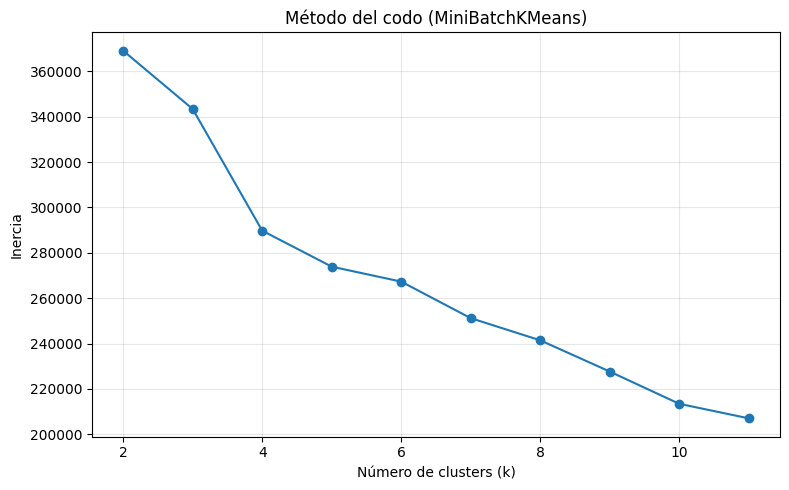


Resumen de tamaño de clusters (k = 4):
         n_unidades  porcentaje
cluster                        
0             46145       24.93
1             43541       23.52
2             51779       27.97
3             43644       23.58

Distribuciones porcentuales por variable y cluster:

--- sup_cat (% dentro de cada cluster) ---
sup_cat  < 5 ha  5 a <10 ha  10 a <25 ha  25 a <50 ha  ≥ 50 ha
cluster                                                       
0         66.10       13.93        11.78         4.31     3.87
1          0.00       38.35        30.37        13.71    17.57
2         58.93       18.10        12.81         4.32     5.84
3        100.00        0.00         0.00         0.00     0.00

--- cont_per (% dentro de cada cluster) ---
cont_per  Si contrata permanente  No contrata permanente
cluster                                                 
0                         100.00                    0.00
1                         100.00                    0.00
2                   

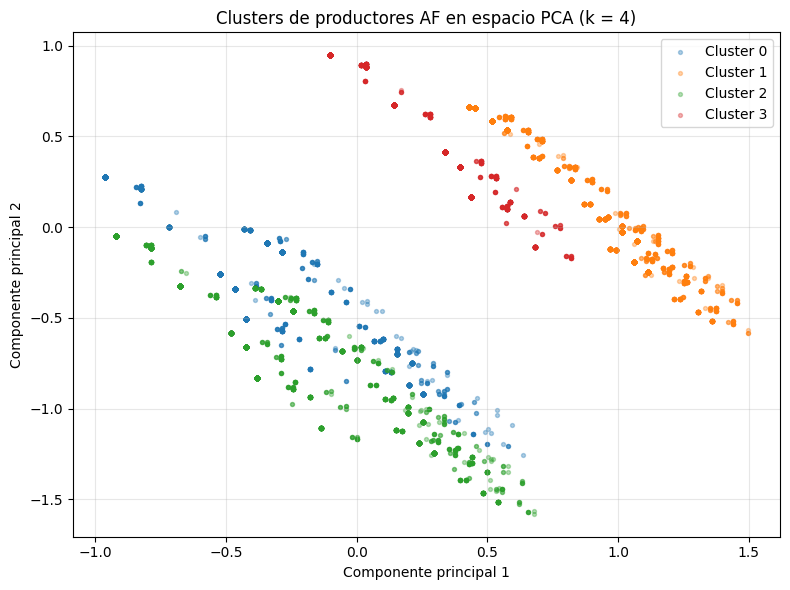

In [ ]:
# ============================================================
# MACHINE LEARNING NO SUPERVISADO – SEGMENTACIÓN AF (ENA 2024)
# Script ordenado de inicio a fin (incluye reducción/eliminación
# de variables y limpieza por nulos)
# ============================================================

# ============================
# 0) LIBRERÍAS
# ============================
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.decomposition import PCA

# ============================
# 1) MONTAR DRIVE + CARGAR STATA
# ============================
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/TRABAJO MIDAGRI 2025/ESTUDIO_AF/DATASET/DATA_AF_cluster.dta'
df = pd.read_stata(ruta)

print("Dimensión base original:", df.shape)
print(df.dtypes)


# Lista final usada en clustering (7 variables)
vars_core = [
    'sup_cat',
    'cont_per',
    'acc_rie',
    'div_cult',
    'asis_tec',
    'act_eq',
    'serv_fin'
]

# Dataframe solo con variables core
df_core = df[vars_core].copy()

# ============================
# 3) LIMPIEZA DE DATOS (core)
#    - Eliminamos filas con NA solo en estas 7 variables
# ============================
df_core = df_core.dropna()
print("Dimensión después de dropna (core):", df_core.shape)

# Asegurar tipo categórico (por seguridad)
for col in vars_core:
    df_core[col] = df_core[col].astype('category')

# Resumen de frecuencias (descriptivo inicial)
print("\nResumen de frecuencias categóricas (muestra ML):")
for col in vars_core:
    print(f"\n=== {col} ===")
    print(df_core[col].value_counts(dropna=False))

# ============================
# 4) ONE-HOT ENCODING → MATRIZ X_df
# ============================
encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore'
)

X_encoded = encoder.fit_transform(df_core[vars_core])
encoded_feature_names = encoder.get_feature_names_out(vars_core)

X_df = pd.DataFrame(
    X_encoded,
    columns=encoded_feature_names,
    index=df_core.index
)

print("\nMatriz X_df (filas, columnas):", X_df.shape)

# ============================
# 5) MÉTODO DEL CODO (MiniBatchKMeans)
# ============================
inertia = []
k_values = range(2, 12)

for k in k_values:
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=1024,
        n_init=10
    )
    km.fit(X_df)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_values), inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo (MiniBatchKMeans)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ============================
# 6) ENTRENAR MODELO FINAL (k óptimo = 4)
# ============================
k_opt = 4

km_final = MiniBatchKMeans(
    n_clusters=k_opt,
    random_state=42,
    batch_size=1024,
    n_init=10
)

labels_final = km_final.fit_predict(X_df)

# DataFrame con variables originales + cluster
df_clusters = df_core.copy()
df_clusters['cluster'] = labels_final

# Tamaño de clusters (abs y %)
tam_clusters = (
    df_clusters['cluster']
    .value_counts()
    .sort_index()
    .rename('n_unidades')
    .to_frame()
)

tam_clusters['porcentaje'] = (tam_clusters['n_unidades'] / len(df_clusters) * 100).round(2)
print("\nResumen de tamaño de clusters (k = 4):")
print(tam_clusters)

# ============================
# 7) PERFILES POR CLUSTER (% por categoría)
# ============================
print("\nDistribuciones porcentuales por variable y cluster:")
for var in vars_core:
    tabla = pd.crosstab(df_clusters['cluster'], df_clusters[var], normalize='index') * 100
    tabla = tabla.round(2)
    print(f"\n--- {var} (% dentro de cada cluster) ---")
    print(tabla)

# ============================
# 8) PERFIL RESUMIDO (moda + % moda por cluster y variable)
# ============================
resumen_detallado = []
clusters_orden = sorted(df_clusters['cluster'].unique())

for cl in clusters_orden:
    sub = df_clusters[df_clusters['cluster'] == cl]
    n_cl = len(sub)
    pct_cl = n_cl / len(df_clusters) * 100

    fila = {
        'cluster': cl,
        'n_unidades': n_cl,
        'porcentaje': round(pct_cl, 2)
    }

    for var in vars_core:
        vc = sub[var].value_counts(normalize=True)
        cat_moda = vc.index[0]
        pct_moda = vc.iloc[0] * 100
        fila[var] = f"{cat_moda} ({pct_moda:.1f}%)"

    resumen_detallado.append(fila)

perfil_clusters = pd.DataFrame(resumen_detallado)
print("\nPerfil resumido de clusters (k = 4):")
print(perfil_clusters)

# ============================
# 9) VISUALIZACIÓN: PCA 2D + scatter por cluster
# ============================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_df)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X_df.index)
pca_df['cluster'] = labels_final

# Muestra para que el gráfico no sea pesado
n_plot = min(15000, len(pca_df))
plot_sample = pca_df.sample(n=n_plot, random_state=42).copy()

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(figsize=(8, 6))
for cl in sorted(plot_sample['cluster'].unique()):
    sub = plot_sample[plot_sample['cluster'] == cl]
    plt.scatter(
        sub['PC1'], sub['PC2'],
        s=8, alpha=0.35,
        color=colors[cl],
        label=f'Cluster {cl}'
    )

plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Clusters de productores AF en espacio PCA (k = 4)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#guardando modelo
import joblib
joblib.dump(km_final, "kmeans_model.pkl")

#cargo mi modelo que he guardado
modelo_load=joblib.load("kmeans_model.pkl")

# Cargando nueva data
nuevas_observaciones_encoded[0, 3] = 1 # sup_cat_< 5 ha
nuevas_observaciones_encoded[0, 6] = 1 # cont_per_Si contrata permanente
nuevas_observaciones_encoded[0, 7] = 1 # acc_rie_Si acceso al riego
nuevas_observaciones_encoded[0, 11] = 1 # div_cult_Monocultivo
nuevas_observaciones_encoded[0, 14] = 1 # asis_tec_Sin apoyo
nuevas_observaciones_encoded[0, 18] = 1 # act_eq_Sin maquinaria/equipo
nuevas_observaciones_encoded[0, 20] = 1 # serv_fin_Sin demanda de crédito

nuevas_observaciones_encoded[1, 2] = 1 # sup_cat_5 a <10 ha
nuevas_observaciones_encoded[1, 6] = 1 # cont_per_Si contrata permanente
nuevas_observaciones_encoded[1, 7] = 1 # acc_rie_Si acceso al riego
nuevas_observaciones_encoded[1, 10] = 1 # div_cult_Diversificación media
nuevas_observaciones_encoded[1, 13] = 1 # asis_tec_Capacitación solo
nuevas_observaciones_encoded[1, 16] = 1 # act_eq_Con equipos
nuevas_observaciones_encoded[1, 19] = 1 # serv_fin_Crédito obtenido

nuevas_observaciones_encoded[2, 0] = 1 # sup_cat_10 a <25 ha
nuevas_observaciones_encoded[2, 6] = 1 # cont_per_Si contrata permanente
nuevas_observaciones_encoded[2, 7] = 1 # acc_rie_Si acceso al riego
nuevas_observaciones_encoded[2, 8] = 1 # div_cult_Diversificación alta
nuevas_observaciones_encoded[2, 12] = 1 # asis_tec_Asistencia técnica solo
nuevas_observaciones_encoded[2, 17] = 1 # act_eq_Con maquinaria
nuevas_observaciones_encoded[2, 20] = 1 # serv_fin_Sin demanda de crédito

nuevas_observaciones = nuevas_observaciones_encoded

#Prediciendo con la nueva data
nuevas_observaciones_df = pd.DataFrame(nuevas_observaciones, columns=encoded_feature_names)
predecir = modelo_load.predict(nuevas_observaciones_df)
print(predecir) # resultados: [0 1 2]


[0 1 2]
